In [1]:
import sqlite3
import pandas as pd
import requests
from io import BytesIO
import numpy as np


sqlite_file_url = 'https://github.com/jknecht/baseball-archive-sqlite/releases/download/2022/lahman_1871-2022.sqlite'
response = requests.get(sqlite_file_url)
with open('lahman_1871-2022.sqlite', 'wb') as f:
    f.write(response.content)

sqlite_file = 'lahman_1871-2022.sqlite'

conn = sqlite3.connect(sqlite_file)

#SQL query
#salary_query = "SELECT yearID, sum(salary) as total_payroll FROM Salaries GROUP BY yearID"

salary_query = "SELECT yearID, sum(salary) as total_payroll FROM Salaries WHERE lgID == 'AL' GROUP BY yearID"
team_salaries = pd.read_sql(salary_query, conn)
team_salaries.head()


,yearID,total_payroll
0,1985,134401120.0
1,1986,157716444.0
2,1987,136088747.0
3,1988,157049812.0
4,1989,188771688.0


In [2]:
#SQL query
# AL= american league NL= national league
#salary_query = "SELECT teamID, yearID, sum(salary) as total_payroll FROM Salaries WHERE lgID == 'AL' GROUP BY teamID, yearID"
salary_query = "SELECT teamID, yearID, sum(salary) as total_payroll FROM Salaries GROUP BY teamID, yearID"
# sums up the salaries for each team in each year.

team_salaries = pd.read_sql(salary_query, conn)
team_salaries


,teamID,yearID,total_payroll
0,ATL,1985,14807000.0
1,BAL,1985,11560712.0
2,BOS,1985,10897560.0
3,CAL,1985,14427894.0
4,CHA,1985,9846178.0
...,...,...,...
913,SLN,2016,143053500.0
914,TBA,2016,57097310.0
915,TEX,2016,176038723.0
916,TOR,2016,138701700.0


In [3]:
cursor = conn.cursor()

# Execute the query to get column names of the Teams table
cursor.execute("PRAGMA table_info(Teams)")

# Fetch all rows from the result set
columns_info = cursor.fetchall()

column_names = [column[1] for column in columns_info]
print(column_names)


['yearID', 'lgID', 'teamID', 'franchID', 'divID', 'Rank', 'G', 'Ghome', 'W', 'L', 'DivWin', 'WCWin', 'LgWin', 'WSWin', 'R', 'AB', 'H', '2B', '3B', 'HR', 'BB', 'SO', 'SB', 'CS', 'HBP', 'SF', 'RA', 'ER', 'ERA', 'CG', 'SHO', 'SV', 'IPouts', 'HA', 'HRA', 'BBA', 'SOA', 'E', 'DP', 'FP', 'name', 'park', 'attendance', 'BPF', 'PPF', 'teamIDBR', 'teamIDlahman45', 'teamIDretro']


***PART 1***

**Problem 1**

In [4]:
# #the column G represents the total number of games played and W represents the number of wins
# #wins_query = "SELECT teamID, yearID, W as wins, G as games_played FROM Teams WHERE lgID == 'AL' AND yearID >= 1985"
# wins_query = "SELECT teamID, yearID, W as wins, G as games_played FROM Teams WHERE yearID >= 1985"
# team_wins = pd.read_sql(wins_query, conn)

# # Calculate winning percentage which is ratio of number of wins and total games played for each team in each year
# team_wins['winning_percentage'] = (team_wins['wins'] / team_wins['games_played']) * 100

# team_data = pd.merge(team_salaries, team_wins, on=['teamID', 'yearID']) #combining the two dataFrames
# team_data


In [5]:
#problem 1
team_data_query = """
    SELECT
        t.teamID,
        t.yearID,
        s.total_payroll,
        CAST(t.W AS REAL) / t.G * 100 as winning_percentage
    FROM
        Teams t
    INNER JOIN (
        SELECT
            teamID,
            yearID,
            SUM(salary) as total_payroll
        FROM
            Salaries
        GROUP BY
            teamID,
            yearID
    ) s ON t.teamID = s.teamID AND t.yearID = s.yearID
    WHERE
        t.yearID >= 1985
"""

team_data= pd.read_sql(team_data_query, conn)
team_data


,teamID,yearID,total_payroll,winning_percentage
0,ATL,1985,14807000.0,40.740741
1,BAL,1985,11560712.0,51.552795
2,BOS,1985,10897560.0,49.693252
3,CAL,1985,14427894.0,55.555556
4,CHA,1985,9846178.0,52.147239
...,...,...,...,...
913,SLN,2016,143053500.0,53.086420
914,TBA,2016,57097310.0,41.975309
915,TEX,2016,176038723.0,58.641975
916,TOR,2016,138701700.0,54.938272


In [6]:
print(team_data.isnull().sum()) #finding missing data
print(team_salaries.isnull().sum())
#no missing data


teamID                0
yearID                0
total_payroll         0
winning_percentage    0
dtype: int64
teamID           0
yearID           0
total_payroll    0
dtype: int64


The SQL code operates on the assumption that there exist matching teamID and yearID combinations in both the Salaries and Teams databases. To handle for missing data, the SQL query purposefully used an INNER JOIN. As per its design, the Salaries and Teams tables' INNER JOIN only chooses rows that have corresponding teamID and yearID data. This method complies with the assumption of completeness of data by efficiently filtering away entries when team or year information is missing.

The winning % formula, CAST(t.W AS REAL) / t.G * 100 code mitigates potential conflicts that may result from integer division in SQL by ensuring float division by casting the winnings to a real number.



# **Part 2**

**Problem 2**

<function matplotlib.pyplot.show(close=None, block=None)>

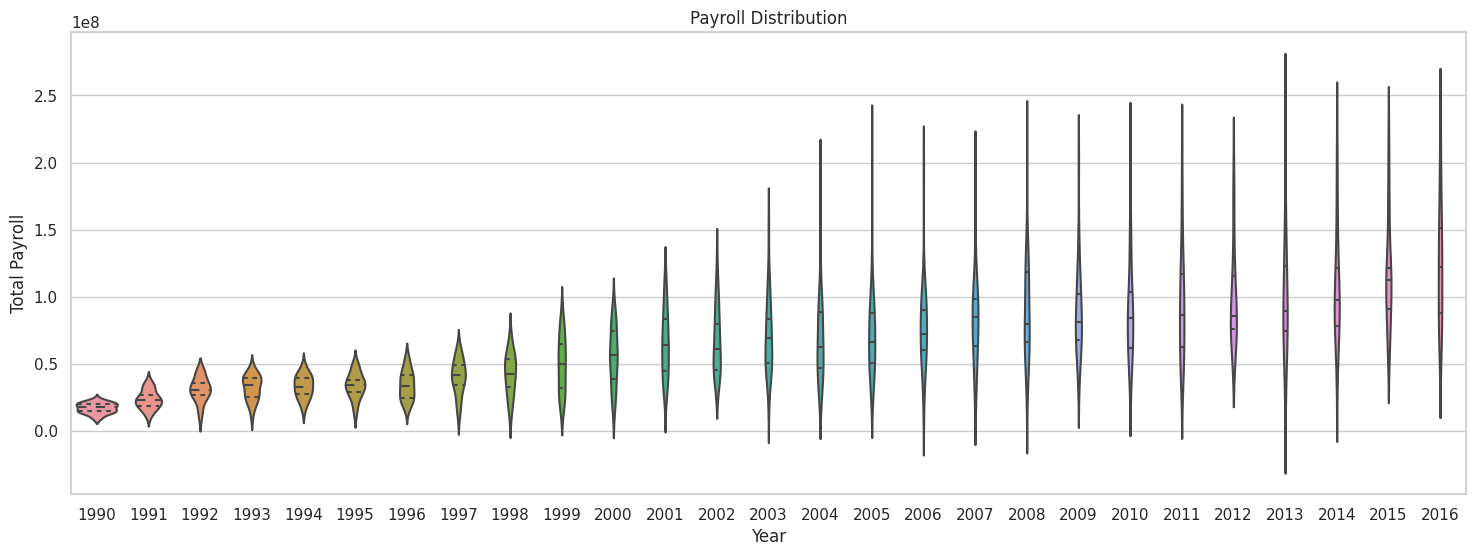

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

#data from 1990-2022
filtered_team_data= team_data[(team_data['yearID']>=1990)&(team_data['yearID']<=2022)]

sns.set(style="whitegrid")
plt.figure(figsize=(18,6))
sns.violinplot(x='yearID',y='total_payroll',data=filtered_team_data,inner='quartile')
plt.title("Payroll Distribution")
plt.xlabel('Year')
plt.ylabel('Total Payroll')
plt.show

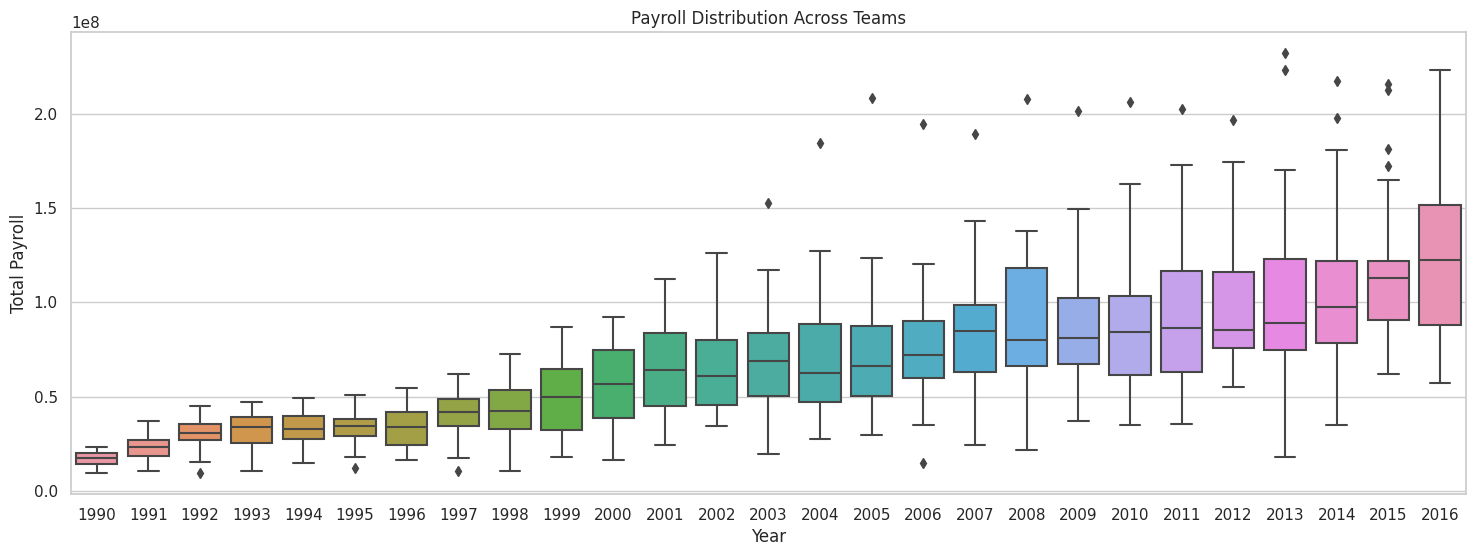

In [8]:
plt.figure(figsize=(18, 6))
sns.boxplot(x='yearID', y='total_payroll', data=filtered_team_data)
plt.title('Payroll Distribution Across Teams')
plt.xlabel('Year')
plt.ylabel('Total Payroll')
plt.show()

Question 1
From the above boxplot: The payroll tends to increase with time

spread:The payroll size distribution is revealed by the interquartile range (IQR), which shows a wide variance between teams.

Central Tendency: Overall, the payroll distribution is positively skewed. This means that most years have a payroll size slightly above average, and there are some years with payrolls larger than the average.

The outliers indicate that the teams had high/low payrolls compared to the majority.


<ipython-input-9-24441ec2ed2b>:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='yearID', y='total_payroll', data=filtered_team_data, estimator=np.mean, ci=None, color='green', label='Mean Payroll')


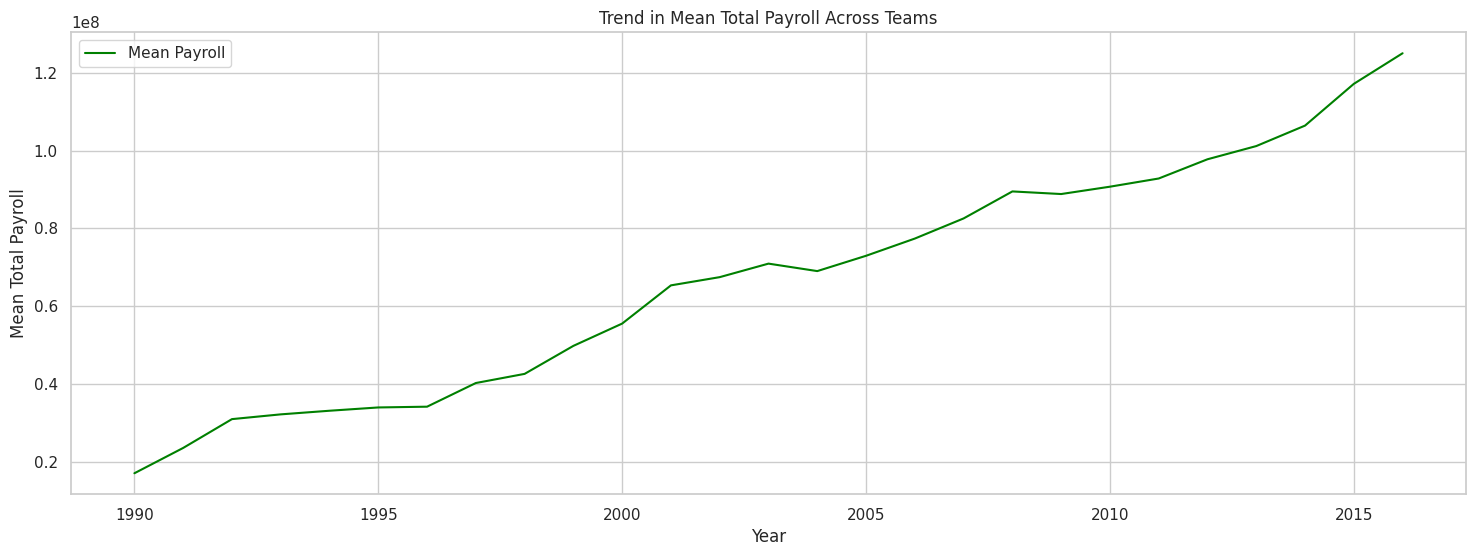

In [9]:
#problem 3
# Calculate the mean payroll for each year
mean_payroll_by_year = filtered_team_data.groupby('yearID')['total_payroll'].mean().reset_index()

plt.figure(figsize=(18, 6))
sns.lineplot(x='yearID', y='total_payroll', data=filtered_team_data, estimator=np.mean, ci=None, color='green', label='Mean Payroll')
plt.title('Trend in Mean Total Payroll Across Teams')
plt.xlabel('Year')
plt.ylabel('Mean Total Payroll')
plt.legend()
plt.show()

In [10]:
filtered_team_data

,teamID,yearID,total_payroll,winning_percentage
130,ATL,1990,14555501.0,40.123457
131,BAL,1990,9680084.0,47.204969
132,BOS,1990,20558333.0,54.320988
133,CAL,1990,21720000.0,49.382716
134,CHA,1990,9491500.0,58.024691
...,...,...,...,...
913,SLN,2016,143053500.0,53.086420
914,TBA,2016,57097310.0,41.975309
915,TEX,2016,176038723.0,58.641975
916,TOR,2016,138701700.0,54.938272


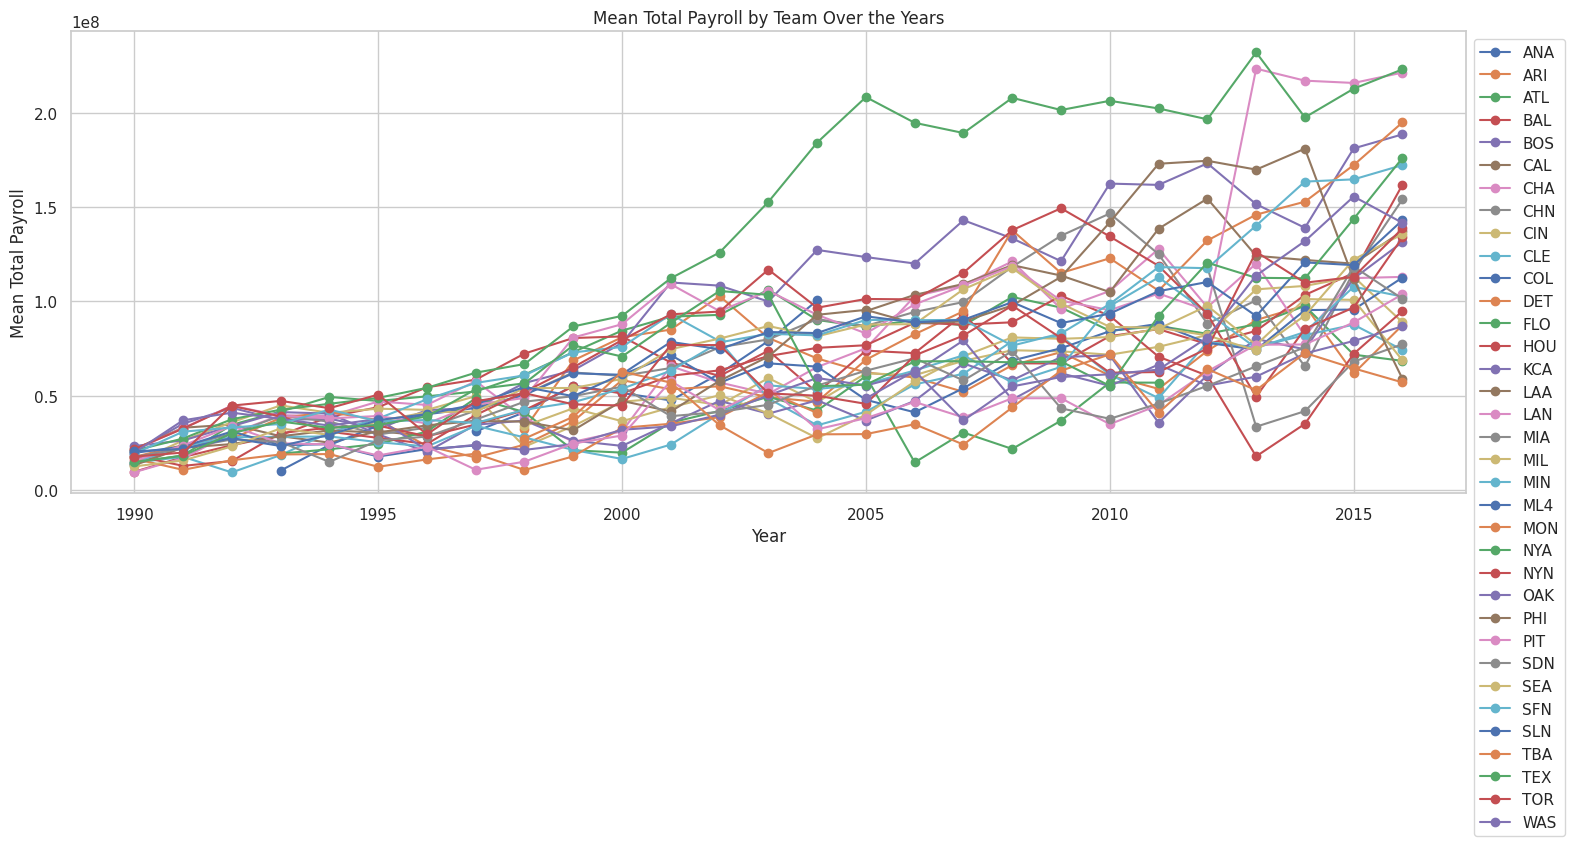

In [11]:
# Calculate the mean payroll for each team over the years
df_mean_payroll = filtered_team_data.groupby(['yearID', 'teamID'])['total_payroll'].mean().unstack()

plt.figure(figsize=(18, 6))
for team in df_mean_payroll.columns:
    plt.plot(df_mean_payroll.index, df_mean_payroll[team], label=team, marker='o')

plt.title('Mean Total Payroll by Team Over the Years')
plt.xlabel('Year')
plt.ylabel('Mean Total Payroll')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()


In [12]:
#problem 4
team_data['time_period'] = pd.cut(team_data['yearID'], bins=5, labels=['Period 1', 'Period 2', 'Period 3', 'Period 4', 'Period 5'])

mean_data_by_period = team_data.groupby(['time_period', 'teamID']).agg(
    mean_winning_percentage=('winning_percentage', 'mean'),
    mean_total_payroll=('total_payroll', 'mean')
).reset_index()



In [13]:
mean_data_by_period = mean_data_by_period.dropna(subset = ['mean_total_payroll', 'mean_winning_percentage'])

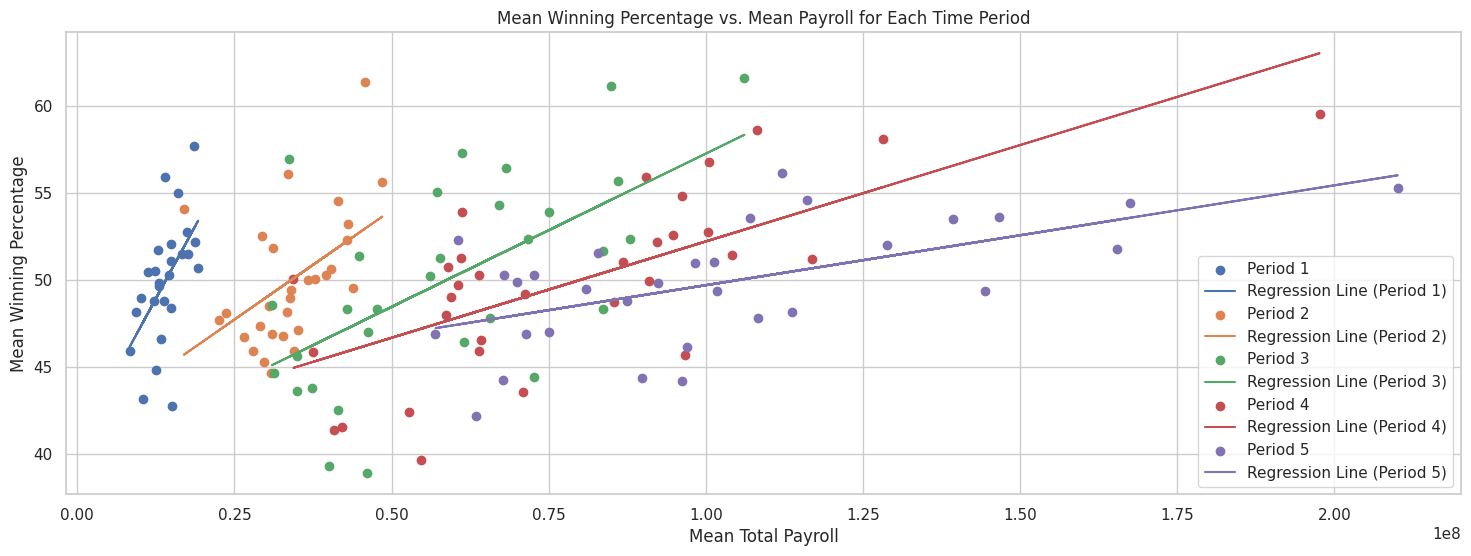

In [14]:
plt.figure(figsize=(18,6))

for period in mean_data_by_period['time_period'].unique():
    subset_data = mean_data_by_period[mean_data_by_period['time_period'] == period]

    # Add regression line using NumPy's polyfit
    slope, intercept = np.polyfit(subset_data['mean_total_payroll'], subset_data['mean_winning_percentage'], 1)
    regression_line = np.polyval([slope, intercept], subset_data['mean_total_payroll'])

    plt.scatter(subset_data['mean_total_payroll'], subset_data['mean_winning_percentage'], label=period)
    plt.plot(subset_data['mean_total_payroll'], regression_line, label=f'Regression Line ({period})', linestyle='-')

plt.title('Mean Winning Percentage vs. Mean Payroll for Each Time Period')
plt.xlabel('Mean Total Payroll')
plt.ylabel('Mean Winning Percentage')
plt.legend()
plt.show()

We note that both mean winning percentage and mean payroll grow as period increases. Additionally, we see that the mean payroll spread increases considerably with period. The linear regression graphs are thus located directly over their prior time periods.

This might mean that clubs who win their league on a regular basis prioritize spending money on players who can win, which raises the payroll of the team as a whole.



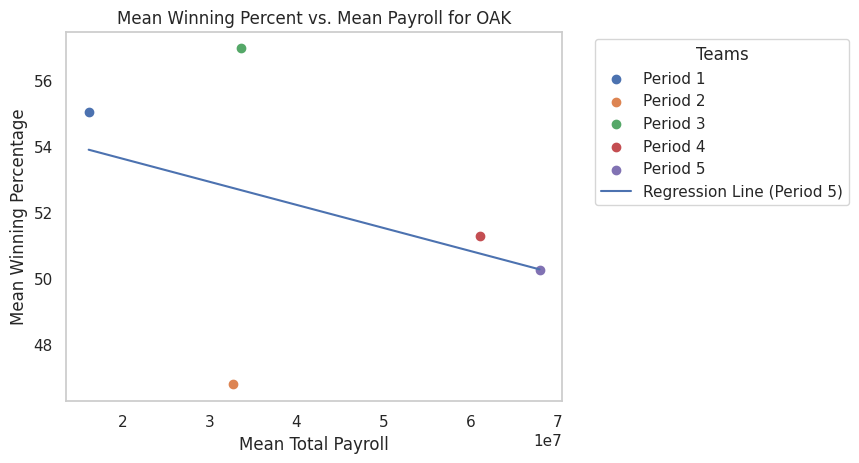

In [15]:
#for oakland
oakland_data = mean_data_by_period[mean_data_by_period['teamID'] == 'OAK']
for period in oakland_data['time_period']:
    period_data = oakland_data[oakland_data['time_period'] == period]

    plt.scatter(period_data['mean_total_payroll'], period_data['mean_winning_percentage'], label=period)

slope, intercept = np.polyfit(oakland_data['mean_total_payroll'], oakland_data['mean_winning_percentage'], 1)
regression_line = np.polyval([slope, intercept], oakland_data['mean_total_payroll'])

# plotting the regression line
plt.plot(oakland_data['mean_total_payroll'], regression_line, label=f'Regression Line ({period})')

plt.title('Mean Winning Percent vs. Mean Payroll for OAK')
plt.xlabel('Mean Total Payroll')
plt.ylabel('Mean Winning Percentage')
plt.grid()
plt.legend(title='Teams', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Based on the plot, the Oakland A's mean winning percentage in the period 3 is high compared to other periods

The Oakland A's remarkable rise in winning percentage while keeping their payroll level is the foundation of the money ball

**PART 3**

In [16]:
#problem 5
yearly_stats = team_data.groupby('yearID')['total_payroll'].agg(['mean', 'std']).reset_index()
yearly_stats.columns = ['yearID', 'avg_payroll_yearly_stats', 'std_payroll_yearly_stats']

team_data = pd.merge(team_data, yearly_stats, on='yearID')

team_data['standardized_payroll'] = (team_data['total_payroll'] - team_data['avg_payroll_yearly_stats']) / team_data['std_payroll_yearly_stats']

team_data


,teamID,yearID,total_payroll,winning_percentage,time_period,avg_payroll_yearly_stats,std_payroll_yearly_stats,standardized_payroll
0,ATL,1985,14807000.0,40.740741,Period 1,1.007557e+07,2.470845e+06,1.914905
1,BAL,1985,11560712.0,51.552795,Period 1,1.007557e+07,2.470845e+06,0.601068
2,BOS,1985,10897560.0,49.693252,Period 1,1.007557e+07,2.470845e+06,0.332678
3,CAL,1985,14427894.0,55.555556,Period 1,1.007557e+07,2.470845e+06,1.761474
4,CHA,1985,9846178.0,52.147239,Period 1,1.007557e+07,2.470845e+06,-0.092838
...,...,...,...,...,...,...,...,...
913,SLN,2016,143053500.0,53.086420,Period 5,1.250046e+08,4.663199e+07,0.387050
914,TBA,2016,57097310.0,41.975309,Period 5,1.250046e+08,4.663199e+07,-1.456238
915,TEX,2016,176038723.0,58.641975,Period 5,1.250046e+08,4.663199e+07,1.094402
916,TOR,2016,138701700.0,54.938272,Period 5,1.250046e+08,4.663199e+07,0.293728


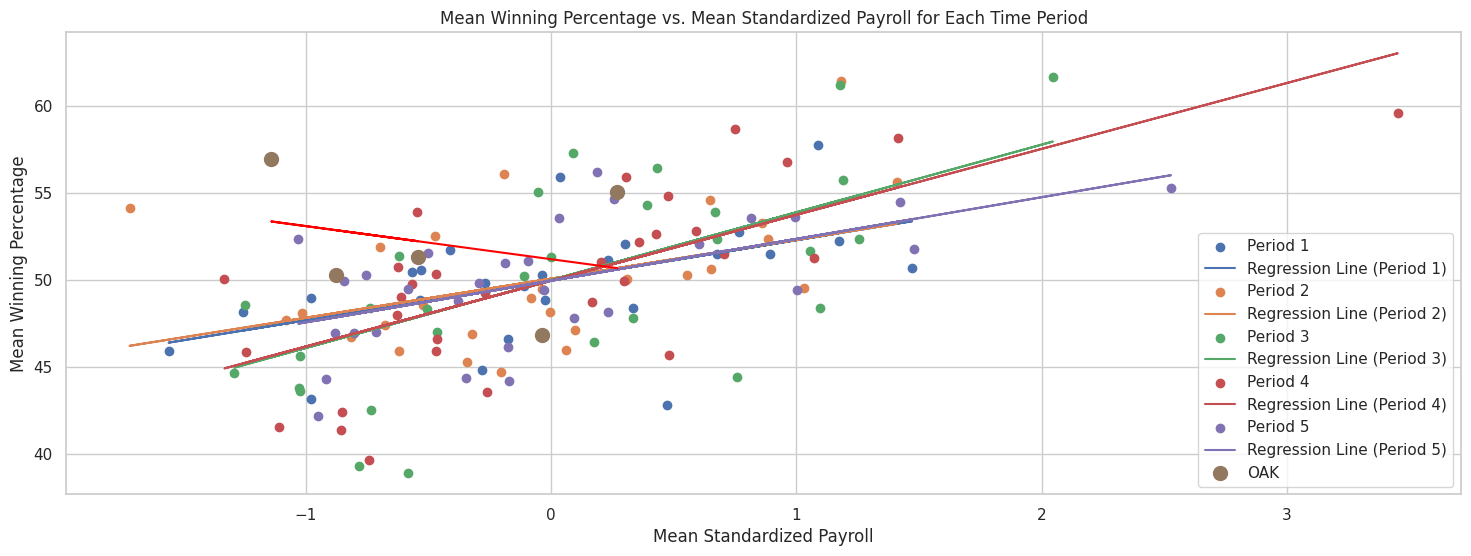

In [17]:
# #problem 6
team_data['time_period'] = pd.cut(team_data['yearID'], bins=5, labels=['Period 1', 'Period 2', 'Period 3', 'Period 4', 'Period 5'])

team_data = team_data.groupby(['time_period', 'teamID']).agg(
    mean_winning_percentage=('winning_percentage', 'mean'),
    mean_standardized_payroll=('standardized_payroll', 'mean')
).reset_index()


team_data = team_data.dropna(subset = ['mean_standardized_payroll', 'mean_winning_percentage'])

# Plot scatter plots and regression lines
plt.figure(figsize=(18, 6))

for period in mean_data_by_period['time_period'].unique():
    subset_data = team_data[team_data['time_period'] == period]

    slope, intercept = np.polyfit(subset_data['mean_standardized_payroll'], subset_data['mean_winning_percentage'], 1)
    regression_line = np.polyval([slope, intercept], subset_data['mean_standardized_payroll'])

    plt.scatter(subset_data['mean_standardized_payroll'], subset_data['mean_winning_percentage'], label=period)
    plt.plot(subset_data['mean_standardized_payroll'], regression_line, label=f'Regression Line ({period})', linestyle='-')

oakland_data = team_data[team_data['teamID'] == 'OAK']
slope_oakland, intercept_oakland = np.polyfit(oakland_data['mean_standardized_payroll'], oakland_data['mean_winning_percentage'], 1)
regression_line_oakland = np.polyval([slope_oakland, intercept_oakland], oakland_data['mean_standardized_payroll'])

plt.scatter(oakland_data['mean_standardized_payroll'], oakland_data['mean_winning_percentage'], label='OAK', marker='o', s=100)
plt.plot(oakland_data['mean_standardized_payroll'], regression_line_oakland, linestyle='-', color='red')

plt.title('Mean Winning Percentage vs. Mean Standardized Payroll for Each Time Period')
plt.xlabel('Mean Standardized Payroll')
plt.ylabel('Mean Winning Percentage')
plt.legend()
plt.show()


Question 3

In Problem 4, the scatter plots and regression lines were created using the original payroll variable. In contrast, Problem 6 involved creating plots using the mean standardized payroll variable, which was obtained by standardizing the payroll variable conditioned on the year.
 Standardizing the payroll allows for a more meaningful comparison of teams' spending efficiency across years.Which is done in problem 6.

 Problem 6 enhances the interpretability of the plots by allowing a more accurate assessment of how team spending relates to performance over time, independent of overall changes in payroll values.
 When their total payouts are similar, we can compare the mean winning percentages for each period.



**Expected wins**

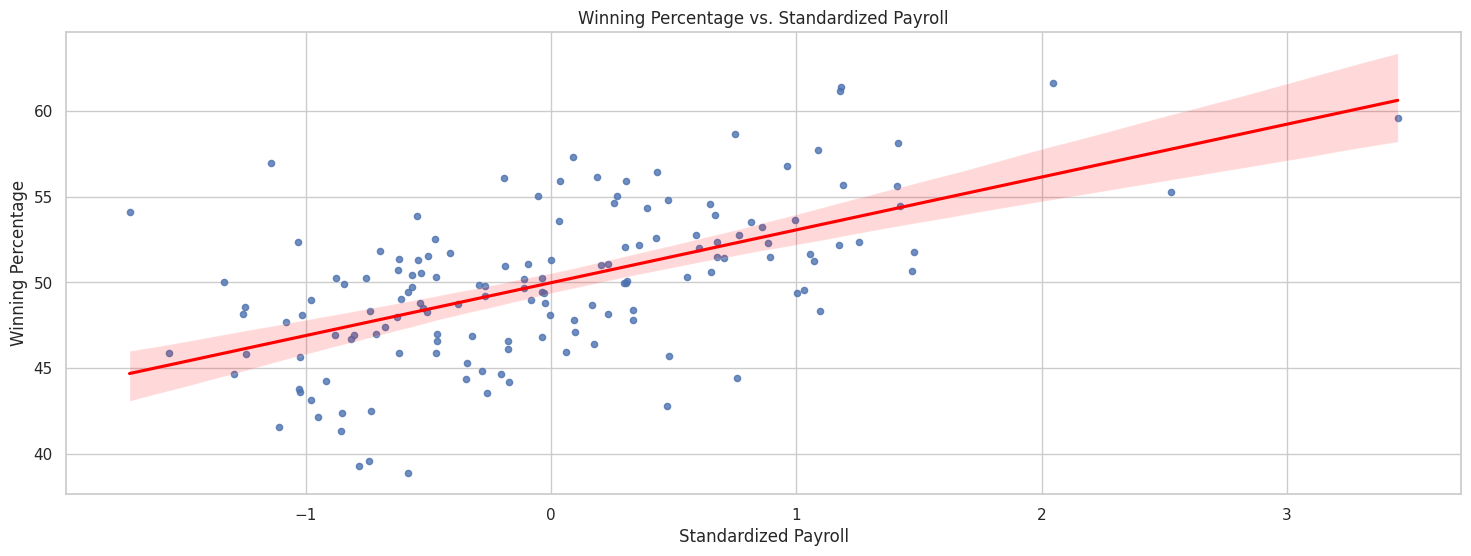

In [18]:
#problem 7

# Scatter plot and regression line
plt.figure(figsize=(18,6))
sns.regplot(x='mean_standardized_payroll', y='mean_winning_percentage', data=team_data, scatter_kws={'s': 20}, line_kws={'color': 'red'})

plt.title('Winning Percentage vs. Standardized Payroll')
plt.xlabel('Standardized Payroll')
plt.ylabel('Winning Percentage')
plt.grid(True)
plt.show()

**Spending efficiency**

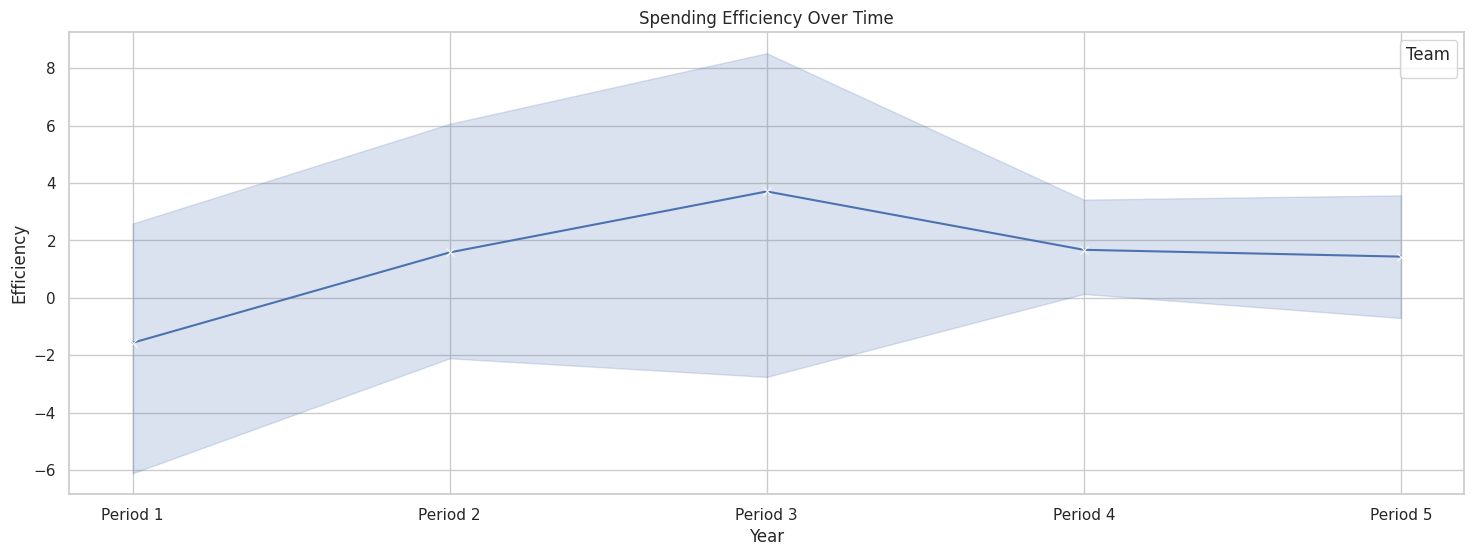

In [19]:
#problem 8

def calculate_efficiency(row):
  expected_win_pct = 50+2.5*row['mean_standardized_payroll']
  efficiency = row['mean_winning_percentage']-expected_win_pct
  return efficiency

team_data['efficiency']= team_data.apply(calculate_efficiency,axis=1)
selected_teams=['OAK','BOS','NYA','ATL','TBA']
selected_teams_data= team_data[team_data['teamID'].isin(selected_teams)]

plt.figure(figsize=(18,6))
sns.lineplot(x='time_period',y='efficiency',data= selected_teams_data, marker='x')
plt.title('Spending Efficiency Over Time')
plt.xlabel('Year')
plt.ylabel('Efficiency')
plt.legend(title='Team')
plt.grid(True)
plt.show()


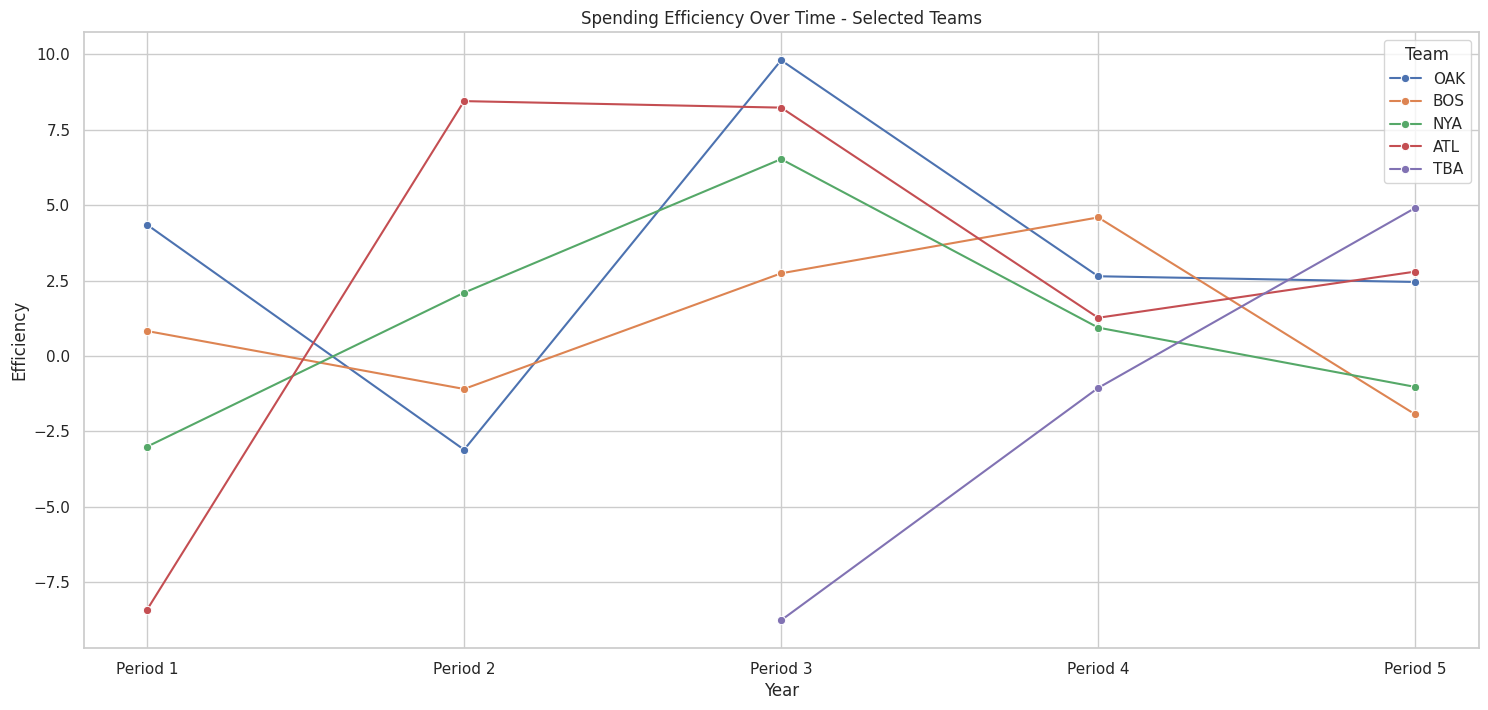

In [20]:
# Define a function to calculate efficiency for each row
def calculate_efficiency(row):
    expected_win_pct = 50 + 2.5 * row['mean_standardized_payroll']
    efficiency = row['mean_winning_percentage'] - expected_win_pct
    return efficiency

team_data['efficiency'] = team_data.apply(calculate_efficiency, axis=1)

selected_teams = ['OAK', 'BOS', 'NYA', 'ATL', 'TBA']

plt.figure(figsize=(18, 8))
for team in selected_teams:
    team_data_subset = team_data[team_data['teamID'] == team]
    sns.lineplot(x='time_period', y='efficiency', data=team_data_subset, label=team, marker='o')

plt.title('Spending Efficiency Over Time - Selected Teams')
plt.xlabel('Year')
plt.ylabel('Efficiency')
plt.legend(title='Team')
plt.grid(True)
plt.show()


Question 4:

representation of data using lines allows for easier visualization and comparison. It's clear that Oakland's efficiency has improved significantly during period 3.

In order to determine Oakland's level of effectiveness throughout the Moneyball era, it is crucial to keep in mind that the focus of Moneyball is the 2002 season. Plot demonstrates that Oakland's team efficiency was close to 10 throughout that period, indicating that it was a strong showing in comparison to previous years. But it's important to remember that Oakland had the second-lowest payroll in Major League Baseball that season, so they had to put player efficiency and development first. Their mediocre work is all the more remarkable for this.
